In [1]:
import os
import numpy as np  
from PIL import Image
import tensorflow as tf 
from keras import backend as K           
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import sklearn.metrics as metrics
from keras.models import load_model
from skimage.transform import resize
from keras.preprocessing import image  
from sklearn.metrics import roc_curve
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.metrics import roc_auc_score


## Load dataset

In [2]:
folder_benign_train = r'C:\Users\11609\Desktop\sem1\ML\cw\cousework2\archive\train\benign'
folder_malignant_train = r'C:\Users\11609\Desktop\sem1\ML\cw\cousework2\archive\train\malignant'

folder_benign_test = r'C:\Users\11609\Desktop\sem1\ML\cw\cousework2\archive\test\benign'
folder_malignant_test = r'C:\Users\11609\Desktop\sem1\ML\cw\cousework2\archive\test\malignant'

In [3]:
# Load in training pictures 
ims_benign = [Image.open(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array([np.array(im) for im in ims_benign])

ims_malignant = [Image.open(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array([np.array(im) for im in ims_malignant])
# Create labels for training data
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

# Load in testing pictures 
ims_benign_test = [Image.open(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array([np.array(im) for im in ims_benign_test])

ims_malignant_test = [Image.open(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array([np.array(im) for im in ims_malignant_test])
# Create labels for testing data

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])

In [4]:
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

## data splitting

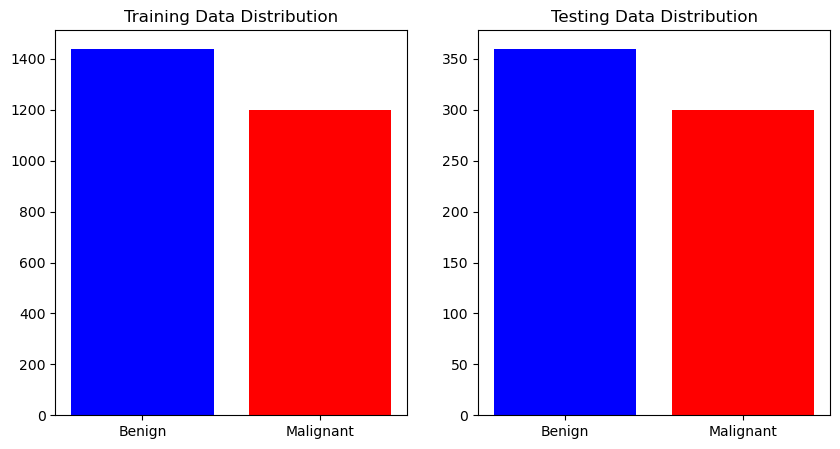

In [5]:
train_benign_count = np.sum(y_train == 0)
train_malignant_count = np.sum(y_train == 1)
test_benign_count = np.sum(y_test == 0)
test_malignant_count = np.sum(y_test == 1)
labels = ['Benign', 'Malignant']
train_counts = [train_benign_count, train_malignant_count]
test_counts = [test_benign_count, test_malignant_count]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.bar(labels, train_counts, color=['blue', 'red'])
ax1.set_title('Training Data Distribution')
ax2.bar(labels, test_counts, color=['blue', 'red'])
ax2.set_title('Testing Data Distribution')
plt.show()

## dataset processing 

In [6]:
# random data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

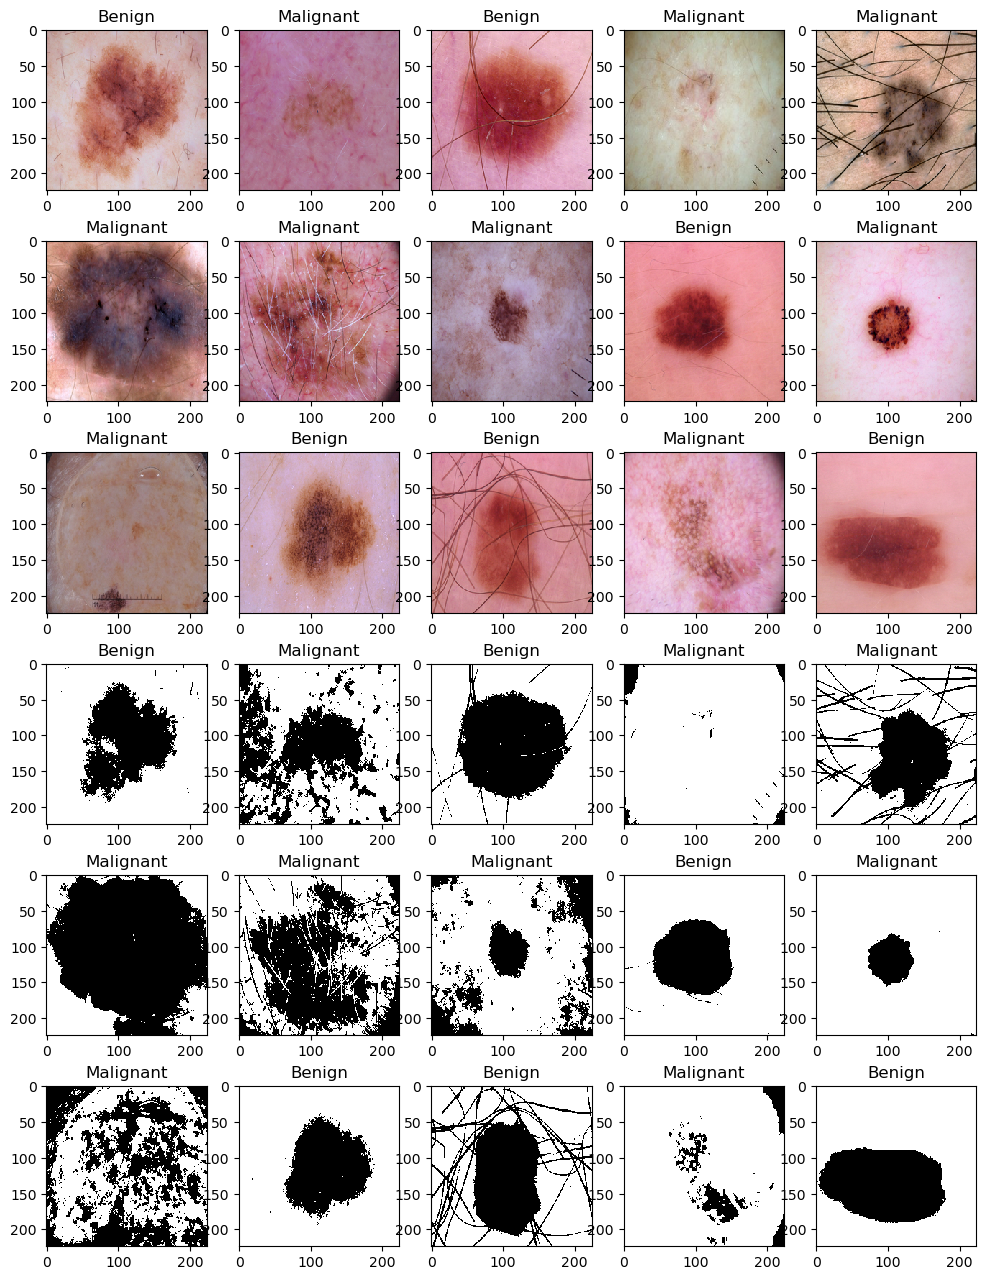

In [7]:
w = 40
h = 30
fig = plt.figure(figsize=(12, 16))  
columns = 5
rows = 6  

for i in range(1, columns * rows + 1):
    ax = fig.add_subplot(rows, columns, i)
    
    if i <= columns * (rows // 2):
        if y_train[i] == 0:
            ax.title.set_text('Benign')
        else:
            ax.title.set_text('Malignant')
        plt.imshow(X_train[i], interpolation='nearest')
    else:
        if y_train[i - columns * (rows // 2)] == 0:
            ax.title.set_text('Benign')
        else:
            ax.title.set_text('Malignant')
        gray_img = cv2.cvtColor(X_train[i - columns * (rows // 2)], cv2.COLOR_BGR2GRAY) 
        _, binary_img = cv2.threshold(gray_img, 128, 255, cv2.THRESH_BINARY)
        plt.imshow(binary_img, cmap='gray', interpolation='nearest')

plt.show()

## Ensemble ANN model

In [8]:
def preprocess_image(img):
    # Grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Binarization
    _, binary_img = cv2.threshold(gray_img, 128, 255, cv2.THRESH_BINARY)
    
    return binary_img
# train set
X_train_processed = np.array([preprocess_image(img) for img in X_train])

# test set
X_test_processed = np.array([preprocess_image(img) for img in X_test])

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


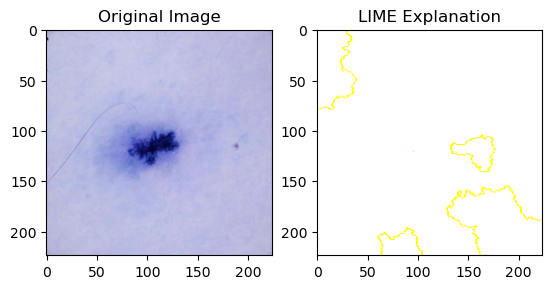

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense

# Load your Keras model
model_path = 'C:\\Users\\11609\\Desktop\\sem1\\ML\\cw\\cousework2\\mymodel.h5'  
model_binary_crossentropy = load_model(model_path)

# Function to preprocess images for interpretation
def preprocess_image_for_interpretation(image_path):
    img = cv2.imread(image_path)
    input_size = (224, 224)  
    img = cv2.resize(img, input_size)
    return img

# Function to preprocess images for prediction
def preprocess_image_for_prediction(img):
    input_size = (224, 224)  
    img = cv2.resize(img, input_size)
    
    # Grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Binarization
    _, binary_img = cv2.threshold(gray_img, 128, 255, cv2.THRESH_BINARY)

    return binary_img

# Function to predict with the model
def predict_fn(images):
    # Assuming images is a 4D array (batch_size, height, width, channels)
    flattened_images = np.array([preprocess_image_for_prediction(img) for img in images])
    flattened_images = flattened_images.reshape((flattened_images.shape[0], -1))
    return model_binary_crossentropy.predict(flattened_images)

# Load your image for interpretation
image_to_interpret_path = r'C:\Users\11609\Desktop\sem1\ML\cw\cousework2\archive\test\benign\1.jpg'
image_to_interpret_rgb = preprocess_image_for_interpretation(image_to_interpret_path)

# Create LIME explainer
explainer = lime_image.LimeImageExplainer()

# Explain the prediction for the selected image
explanation = explainer.explain_instance(image_to_interpret_rgb, predict_fn, top_labels=2, hide_color=0, num_samples=1000)

# Display the original image
plt.subplot(1, 2, 1)
plt.imshow(image_to_interpret_rgb)
plt.title('Original Image')

# Display the LIME explanation
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.title('LIME Explanation')

plt.show()

## Defined Lost

In [9]:
# Custom Sparse Categorical Crossentropy Loss
def custom_sparse_categorical_crossentropy(y_true, y_pred):
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=False)
    penalty = 0.01
    total_loss = loss + penalty
    return total_loss

# Custom Loss V2
def custom_loss_v2(y_true, y_pred):
    mse_loss = tf.keras.losses.mean_squared_error(y_true, y_pred)
    new_penalty = 0.01
    total_loss = mse_loss + new_penalty
    return total_loss

def custom_binary_crossentropy(y_true, y_pred):
    epsilon = 1e-15  # Small constant to avoid log(0)
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)  # Clip predicted probabilities to avoid log(0)
    
    # Binary Crossentropy Loss Calculation
    loss = - (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    
    return np.mean(loss)

Epoch 1/8
149/149 [==============================] - 4s 4ms/step - loss: 232.0395 - accuracy: 0.5402 - val_loss: 61.9772 - val_accuracy: 0.5227
Epoch 2/8
149/149 [==============================] - 0s 3ms/step - loss: 59.6392 - accuracy: 0.5815 - val_loss: 85.2743 - val_accuracy: 0.4886
Epoch 3/8
149/149 [==============================] - 0s 3ms/step - loss: 72.9898 - accuracy: 0.5963 - val_loss: 27.9580 - val_accuracy: 0.6174
Epoch 4/8
149/149 [==============================] - 0s 3ms/step - loss: 38.2450 - accuracy: 0.6022 - val_loss: 55.9542 - val_accuracy: 0.5530
Epoch 5/8
149/149 [==============================] - 0s 3ms/step - loss: 32.2079 - accuracy: 0.6241 - val_loss: 18.6391 - val_accuracy: 0.6136
Epoch 6/8
149/149 [==============================] - 0s 3ms/step - loss: 7.9252 - accuracy: 0.7054 - val_loss: 19.1729 - val_accuracy: 0.4962
Epoch 7/8
149/149 [==============================] - 0s 3ms/step - loss: 7.0429 - accuracy: 0.7063 - val_loss: 5.4262 - val_accuracy: 0.6818
E

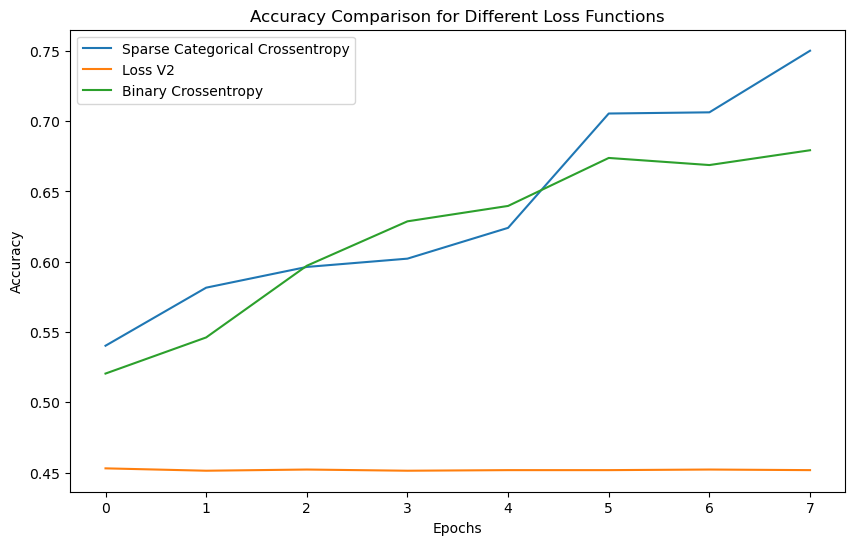

In [10]:
# Custom Sparse Categorical Crossentropy Loss
def custom_sparse_categorical_crossentropy(y_true, y_pred):
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=False)
    penalty = 0.01
    total_loss = loss + penalty
    return total_loss

# Custom Loss V2
def custom_loss_v2(y_true, y_pred):
    mse_loss = tf.keras.losses.mean_squared_error(y_true, y_pred)
    new_penalty = 0.01
    total_loss = mse_loss + new_penalty
    return total_loss

def custom_binary_crossentropy(y_true, y_pred):
    epsilon = 1e-15  # Small constant to avoid log(0)
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)  # Clip predicted probabilities to avoid log(0)
    
    # Binary Crossentropy Loss Calculation
    loss = - (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    
    return np.mean(loss)

# Assuming y_train is one-dimensional (e.g., [0, 1, 0, 1, ...])
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=2)

X_train_flatten = X_train_processed.reshape((X_train_processed.shape[0], -1))

# Build and train the ANN with custom binary crossentropy loss
# 
#  the data
X_train_flatten = X_train_processed.reshape((X_train_processed.shape[0], -1))
X_test_flatten = X_test_processed.reshape((X_test_processed.shape[0], -1))

# Build and train the ANN with custom sparse categorical crossentropy loss function
model_sparse_categorical = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_flatten.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(2, activation='softmax')
])
model_sparse_categorical.compile(optimizer='adam', loss=custom_sparse_categorical_crossentropy, metrics=['accuracy'])
history_sparse_categorical = model_sparse_categorical.fit(X_train_flatten, y_train, epochs=8, batch_size=16, validation_split=0.1)

# Build and train the ANN with custom loss v2 function
model_loss_v2 = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_flatten.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(2, activation='softmax')
])
model_loss_v2.compile(optimizer='adam', loss=custom_loss_v2, metrics=['accuracy'])
history_loss_v2 = model_loss_v2.fit(X_train_flatten, y_train, epochs=8, batch_size=16, validation_split=0.1)

# Build and train the ANN with binary crossentropy loss function
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=2)

X_train_flatten = X_train_processed.reshape((X_train_processed.shape[0], -1))

# Build and train the ANN with binary crossentropy loss
model_binary_crossentropy = Sequential()
model_binary_crossentropy.add(Dense(64, activation='relu', input_shape=(X_train_flatten.shape[1],)))
model_binary_crossentropy.add(Dense(32, activation='relu'))
model_binary_crossentropy.add(Dense(16, activation='relu'))
model_binary_crossentropy.add(Dense(2, activation='softmax'))  # Use 'softmax' for binary classification
model_binary_crossentropy.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_binary_crossentropy = model_binary_crossentropy.fit(X_train_flatten, y_train_one_hot, epochs=8, batch_size=16, validation_split=0.1)

# Print the accuracy from the training history
print("Accuracy:", history_binary_crossentropy.history['accuracy'])

plt.figure(figsize=(10, 6))

# Plot for Sparse Categorical Crossentropy Loss
plt.plot(history_sparse_categorical.history['accuracy'], label='Sparse Categorical Crossentropy')

# Plot for Loss V2
plt.plot(history_loss_v2.history['accuracy'], label='Loss V2')

# Plot for Binary Crossentropy Loss
plt.plot(history_binary_crossentropy.history['accuracy'], label='Binary Crossentropy')

plt.title('Accuracy Comparison for Different Loss Functions')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [11]:
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=2)

X_train_flatten = X_train_processed.reshape((X_train_processed.shape[0], -1))

# Build and train the ANN with binary crossentropy loss
model_binary_crossentropy = Sequential()
model_binary_crossentropy.add(Dense(128, activation='relu', input_shape=(X_train_flatten.shape[1],)))
model_binary_crossentropy.add(Dense(64, activation='relu'))
model_binary_crossentropy.add(Dense(32, activation='relu'))
model_binary_crossentropy.add(Dense(16, activation='relu'))
model_binary_crossentropy.add(Dense(2, activation='softmax'))  # Use 'softmax' for binary classification
model_binary_crossentropy.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_binary_crossentropy = model_binary_crossentropy.fit(X_train_flatten, y_train_one_hot, epochs=9, batch_size=16, validation_split=0.1)

Epoch 1/9
149/149 [==============================] - 1s 6ms/step - loss: 235.5247 - accuracy: 0.5529 - val_loss: 71.0576 - val_accuracy: 0.6174
Epoch 2/9
149/149 [==============================] - 1s 5ms/step - loss: 82.1699 - accuracy: 0.5908 - val_loss: 46.4008 - val_accuracy: 0.5114
Epoch 3/9
149/149 [==============================] - 1s 5ms/step - loss: 59.0164 - accuracy: 0.6039 - val_loss: 57.7253 - val_accuracy: 0.6326
Epoch 4/9
149/149 [==============================] - 1s 4ms/step - loss: 53.8223 - accuracy: 0.5984 - val_loss: 64.4504 - val_accuracy: 0.5909
Epoch 5/9
149/149 [==============================] - 1s 4ms/step - loss: 27.0051 - accuracy: 0.6452 - val_loss: 13.1709 - val_accuracy: 0.6667
Epoch 6/9
149/149 [==============================] - 1s 4ms/step - loss: 19.6613 - accuracy: 0.6637 - val_loss: 15.9964 - val_accuracy: 0.5568
Epoch 7/9
149/149 [==============================] - 1s 4ms/step - loss: 14.0175 - accuracy: 0.6793 - val_loss: 13.4320 - val_accuracy: 0.659

In [61]:
def custom_binary_crossentropy(y_true, y_pred):
    epsilon = 1e-7
    y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)
    loss = - (y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))
    return tf.reduce_mean(loss)

# Assuming y_train is one-dimensional (e.g., [0, 1, 0, 1, ...])
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=2)

X_train_flatten = X_train_processed.reshape((X_train_processed.shape[0], -1))

model_binary_crossentropy = Sequential()
model_binary_crossentropy.add(Dense(64, activation='relu', input_shape=(X_train_flatten.shape[1],)))
model_binary_crossentropy.add(Dense(32, activation='relu'))
model_binary_crossentropy.add(Dense(16, activation='relu'))
model_binary_crossentropy.add(Dense(2, activation='softmax'))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0000004)
model_binary_crossentropy.compile(optimizer=optimizer, loss=custom_binary_crossentropy, metrics=['accuracy'])

history_binary_crossentropy = model_binary_crossentropy.fit(X_train_flatten, y_train_one_hot, epochs=14, batch_size=16, validation_split=0.1)

print("Accuracy:", history_binary_crossentropy.history['accuracy'])

Epoch 1/14
149/149 [==============================] - 1s 7ms/step - loss: 5.8585 - accuracy: 0.5601 - val_loss: 5.6304 - val_accuracy: 0.5833
Epoch 2/14
149/149 [==============================] - 0s 3ms/step - loss: 5.3067 - accuracy: 0.6009 - val_loss: 5.1428 - val_accuracy: 0.5871
Epoch 3/14
149/149 [==============================] - 1s 3ms/step - loss: 4.9165 - accuracy: 0.6051 - val_loss: 4.7230 - val_accuracy: 0.5871
Epoch 4/14
149/149 [==============================] - 0s 3ms/step - loss: 4.9450 - accuracy: 0.5963 - val_loss: 4.5366 - val_accuracy: 0.5568
Epoch 5/14
149/149 [==============================] - 0s 3ms/step - loss: 4.4535 - accuracy: 0.5790 - val_loss: 4.3370 - val_accuracy: 0.5720
Epoch 6/14
149/149 [==============================] - 1s 3ms/step - loss: 3.9734 - accuracy: 0.6001 - val_loss: 4.2083 - val_accuracy: 0.5455
Epoch 7/14
149/149 [==============================] - 1s 3ms/step - loss: 3.6917 - accuracy: 0.6094 - val_loss: 4.2219 - val_accuracy: 0.5606
Epoch 

Epoch 1/8
149/149 [==============================] - 1s 6ms/step - loss: 6.9694 - accuracy: 0.5196 - val_loss: 6.8713 - val_accuracy: 0.5303
Epoch 2/8
149/149 [==============================] - 1s 4ms/step - loss: 6.4945 - accuracy: 0.5550 - val_loss: 6.7057 - val_accuracy: 0.5341
Epoch 3/8
149/149 [==============================] - 1s 3ms/step - loss: 6.3013 - accuracy: 0.5697 - val_loss: 6.7090 - val_accuracy: 0.5303
Epoch 4/8
149/149 [==============================] - 1s 3ms/step - loss: 6.2187 - accuracy: 0.5731 - val_loss: 6.8151 - val_accuracy: 0.5417
Epoch 5/8
149/149 [==============================] - 1s 3ms/step - loss: 6.1215 - accuracy: 0.5828 - val_loss: 6.7818 - val_accuracy: 0.5455
Epoch 6/8
149/149 [==============================] - 1s 3ms/step - loss: 6.0218 - accuracy: 0.5862 - val_loss: 6.8889 - val_accuracy: 0.5379
Epoch 7/8
149/149 [==============================] - 0s 3ms/step - loss: 6.0006 - accuracy: 0.5874 - val_loss: 6.7702 - val_accuracy: 0.5341
Epoch 8/8
149

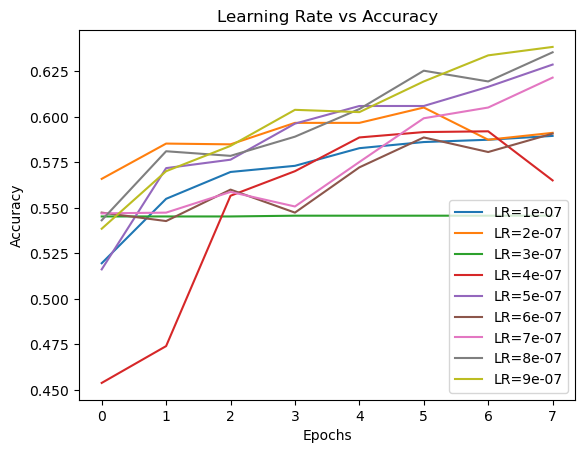

In [64]:
learning_rates = [1e-7, 2e-7, 3e-7, 4e-7, 5e-7, 6e-7, 7e-7, 8e-7,9e-7]

# Create a separate plot for each learning rate
for lr in learning_rates:
    # Build and compile the model with the current learning rate
    model_binary_crossentropy = Sequential()
    model_binary_crossentropy.add(Dense(64, activation='relu', input_shape=(X_train_flatten.shape[1],)))
    model_binary_crossentropy.add(Dense(32, activation='relu'))
    model_binary_crossentropy.add(Dense(16, activation='relu'))
    model_binary_crossentropy.add(Dense(2, activation='softmax'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model_binary_crossentropy.compile(optimizer=optimizer, loss=custom_binary_crossentropy, metrics=['accuracy'])

    # Train the model
    history = model_binary_crossentropy.fit(X_train_flatten, y_train_one_hot, epochs=8, batch_size=16, validation_split=0.1)
    
    # Plot the learning curve for the current learning rate
    plt.plot(history.history['accuracy'], label=f'LR={lr}')

# Customize the plot
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Rate vs Accuracy')
plt.legend()  # Show legend with learning rate labels
plt.show()

In [12]:
def custom_binary_crossentropy(y_true, y_pred):
    epsilon = 1e-7
    y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)
    loss = - (y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))
    return tf.reduce_mean(loss)

# Assuming y_train is one-dimensional (e.g., [0, 1, 0, 1, ...])
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=2)

X_train_flatten = X_train_processed.reshape((X_train_processed.shape[0], -1))

model_binary_crossentropy = Sequential()
model_binary_crossentropy.add(Dense(64, activation='relu', input_shape=(X_train_flatten.shape[1],)))
model_binary_crossentropy.add(Dense(32, activation='relu'))
model_binary_crossentropy.add(Dense(16, activation='relu'))
model_binary_crossentropy.add(Dense(2, activation='softmax'))
optimizer = tf.keras.optimizers.Adam(learning_rate=9e-7)
model_binary_crossentropy.compile(optimizer=optimizer, loss=custom_binary_crossentropy, metrics=['accuracy'])

history_binary_crossentropy = model_binary_crossentropy.fit(X_train_flatten, y_train_one_hot, epochs=14, batch_size=16, validation_split=0.1)

print("Accuracy:", history_binary_crossentropy.history['accuracy'])

Epoch 1/14
149/149 [==============================] - 1s 6ms/step - loss: 6.3674 - accuracy: 0.5769 - val_loss: 5.4501 - val_accuracy: 0.6061
Epoch 2/14
149/149 [==============================] - 0s 3ms/step - loss: 6.2934 - accuracy: 0.5731 - val_loss: 6.1901 - val_accuracy: 0.5833
Epoch 3/14
149/149 [==============================] - 1s 3ms/step - loss: 6.1538 - accuracy: 0.5748 - val_loss: 5.5816 - val_accuracy: 0.6136
Epoch 4/14
149/149 [==============================] - 0s 3ms/step - loss: 5.6395 - accuracy: 0.5921 - val_loss: 5.3750 - val_accuracy: 0.6136
Epoch 5/14
149/149 [==============================] - 1s 4ms/step - loss: 5.4502 - accuracy: 0.6102 - val_loss: 5.1592 - val_accuracy: 0.6098
Epoch 6/14
149/149 [==============================] - 1s 3ms/step - loss: 5.3367 - accuracy: 0.6186 - val_loss: 6.2354 - val_accuracy: 0.5644
Epoch 7/14
149/149 [==============================] - 1s 3ms/step - loss: 5.5830 - accuracy: 0.6085 - val_loss: 4.7278 - val_accuracy: 0.6515
Epoch 

## Seleted Finnal ANN model

In [15]:

# Assuming y_train is one-dimensional (e.g., [0, 1, 0, 1, ...])
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=2)

X_train_flatten = X_train_processed.reshape((X_train_processed.shape[0], -1))

model_binary_crossentropy = Sequential()
model_binary_crossentropy.add(Dense(128, activation='relu', input_shape=(X_train_flatten.shape[1],)))
model_binary_crossentropy.add(Dense(64, activation='relu'))
model_binary_crossentropy.add(Dense(32, activation='relu'))
model_binary_crossentropy.add(Dense(16, activation='relu'))
model_binary_crossentropy.add(Dense(2, activation='softmax'))
optimizer = tf.keras.optimizers.Adam(learning_rate=9e-7)
model_binary_crossentropy.compile(optimizer=optimizer, loss=custom_binary_crossentropy, metrics=['accuracy'])

history_binary_crossentropy = model_binary_crossentropy.fit(X_train_flatten, y_train_one_hot, epochs=14, batch_size=16, validation_split=0.1)

print("Accuracy:", history_binary_crossentropy.history['accuracy'])

Epoch 1/14
149/149 [==============================] - 1s 5ms/step - loss: 7.1531 - accuracy: 0.5487 - val_loss: 7.5135 - val_accuracy: 0.5265
Epoch 2/14
149/149 [==============================] - 1s 4ms/step - loss: 7.0769 - accuracy: 0.5533 - val_loss: 7.1833 - val_accuracy: 0.5379
Epoch 3/14
149/149 [==============================] - 0s 3ms/step - loss: 6.6607 - accuracy: 0.5592 - val_loss: 6.8715 - val_accuracy: 0.5455
Epoch 4/14
149/149 [==============================] - 0s 3ms/step - loss: 6.6756 - accuracy: 0.5702 - val_loss: 6.9725 - val_accuracy: 0.5417
Epoch 5/14
149/149 [==============================] - 0s 3ms/step - loss: 6.6453 - accuracy: 0.5668 - val_loss: 7.2268 - val_accuracy: 0.5379
Epoch 6/14
149/149 [==============================] - 0s 3ms/step - loss: 6.5464 - accuracy: 0.5584 - val_loss: 6.3365 - val_accuracy: 0.5265
Epoch 7/14
149/149 [==============================] - 1s 4ms/step - loss: 5.9747 - accuracy: 0.5820 - val_loss: 5.8015 - val_accuracy: 0.5530
Epoch 

In [52]:
def custom_binary_crossentropy(y_true, y_pred):
    epsilon = 1e-7
    y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)
    loss = - (y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))
    return tf.reduce_mean(loss)

# Assuming y_train is one-dimensional (e.g., [0, 1, 0, 1, ...])
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=2)

X_train_flatten = X_train_processed.reshape((X_train_processed.shape[0], -1))

model_binary_crossentropy = Sequential()
model_binary_crossentropy.add(Dense(128, activation='relu', input_shape=(X_train_flatten.shape[1],)))
model_binary_crossentropy.add(Dense(64, activation='relu'))
model_binary_crossentropy.add(Dense(32, activation='relu'))
model_binary_crossentropy.add(Dense(16, activation='relu'))
model_binary_crossentropy.add(Dense(2, activation='softmax'))
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6)
model_binary_crossentropy.compile(optimizer=optimizer, loss=custom_binary_crossentropy, metrics=['accuracy'])

history_binary_crossentropy = model_binary_crossentropy.fit(X_train_flatten, y_train_one_hot, epochs=38, batch_size=16, validation_split=0.1)

print("Accuracy:", history_binary_crossentropy.history['accuracy'])

Epoch 1/38
149/149 [==============================] - 1s 7ms/step - loss: 6.8833 - accuracy: 0.5440 - val_loss: 6.9359 - val_accuracy: 0.5455
Epoch 2/38
149/149 [==============================] - 1s 4ms/step - loss: 6.2178 - accuracy: 0.5727 - val_loss: 6.6435 - val_accuracy: 0.5455
Epoch 3/38
149/149 [==============================] - 1s 4ms/step - loss: 5.8383 - accuracy: 0.6009 - val_loss: 5.7700 - val_accuracy: 0.6023
Epoch 4/38
149/149 [==============================] - 1s 4ms/step - loss: 5.6937 - accuracy: 0.5929 - val_loss: 6.7738 - val_accuracy: 0.5341
Epoch 5/38
149/149 [==============================] - 1s 4ms/step - loss: 4.9375 - accuracy: 0.6389 - val_loss: 4.9048 - val_accuracy: 0.5909
Epoch 6/38
149/149 [==============================] - 1s 4ms/step - loss: 4.8595 - accuracy: 0.6161 - val_loss: 4.7739 - val_accuracy: 0.5909
Epoch 7/38
149/149 [==============================] - 1s 4ms/step - loss: 4.2717 - accuracy: 0.6271 - val_loss: 5.5463 - val_accuracy: 0.5341
Epoch 

21/21 [==============================] - 0s 4ms/step


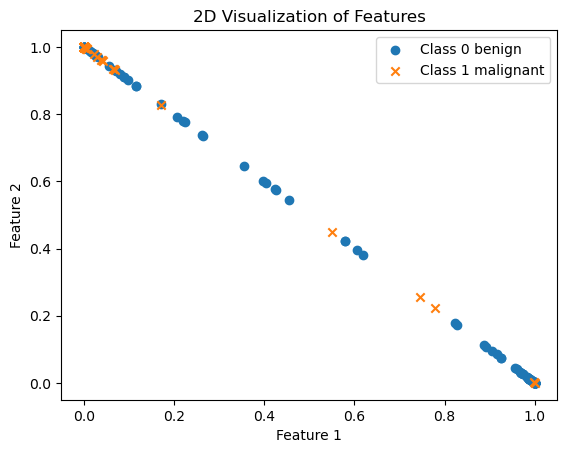

In [53]:
X_train_features = model_binary_crossentropy.predict(X_train_flatten)
X_test_features = model_binary_crossentropy.predict(X_test_flatten)

# The characteristics of the first 200 samples were extracted
X_subset = X_train_features[:200]
# Get the labels for the first 200 samples
y_subset = y_train[:200]
plt.scatter(X_subset[y_subset == 0, 0], X_subset[y_subset == 0, 1], marker='o', label='Class 0 benign')  
plt.scatter(X_subset[y_subset == 1, 0], X_subset[y_subset == 1, 1], marker='x', label='Class 1 malignant')  

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.title('2D Visualization of Features')
plt.show()

In [54]:
X_train_features[0]

array([0.06873795, 0.931262  ], dtype=float32)

In [55]:
y_train[0]

0.0

## Define accuracy, roc-auc, sensitivity, recall, specificity and  precision

In [56]:
threshold = 0.5
def predict_with_threshold(model, data, threshold):
    pred_probs = model.predict(data)  
    pred_binary = (pred_probs[:, 1] > threshold).astype(int)
    return pred_binary
def calculate_accuracy(model, data, labels, threshold):
    pred_binary = predict_with_threshold(model, data, threshold)
    # calculate Accuracy
    accuracy = np.mean(pred_binary == labels)
    return accuracy
def calculate_precision_recall(y_true, y_pred):
    # calculate True Positives (TP), False Positives (FP), False Negatives (FN)
    TP = np.sum((y_true == 1) & (y_pred == 1))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    
    # calculate  Precision and  Recall
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0  
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0  
    
    return precision, recall

In [57]:
from sklearn.metrics import confusion_matrix, roc_auc_score

def predict_with_threshold(model, data, threshold):
    pred_probs = model.predict(data)  
    pred_binary = (pred_probs[:, 1] > threshold).astype(int)
    return pred_binary

def calculate_accuracy(model, data, labels, threshold):
    pred_binary = predict_with_threshold(model, data, threshold)
    accuracy = np.mean(pred_binary == labels)
    return accuracy

def calculate_confusion_matrix(model, data, labels, threshold):
    pred_binary = predict_with_threshold(model, data, threshold)
    conf_matrix = confusion_matrix(labels, pred_binary)
    return conf_matrix

def calculate_roc_auc(model, data, labels):
    pred_probs = model.predict(data)  
    roc_auc = roc_auc_score(labels, pred_probs[:, 1])
    return roc_auc

def calculate_sensitivity_specificity(model, data, labels, threshold):
    pred_binary = predict_with_threshold(model, data, threshold)
    conf_matrix = confusion_matrix(labels, pred_binary)
    TP = conf_matrix[1, 1]
    FN = conf_matrix[1, 0]
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    
    return sensitivity, specificity

def calculate_precision_recall(model, data, labels, threshold):
    pred_binary = predict_with_threshold(model, data, threshold)
    conf_matrix = confusion_matrix(labels, pred_binary)
    TP = conf_matrix[1, 1]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0  
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0  
    
    return precision, recall

def calculate_accuracy_threshold(model, data, labels, threshold):
    pred_probs = model.predict(data)
    pred_binary = (pred_probs[:, 1] > threshold).astype(int)
    accuracy = np.mean(pred_binary == labels)
    return accuracy

In [58]:
class MyKNNClassifier:
    def __init__(self, n_neighbors=3):
        self.n_neighbors = n_neighbors
        self.X_train = None
        self.y_train = None

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        y_pred = []
        for test_point in X_test:
            # Calculate Euclidean distance
            distances = np.sqrt(np.sum((self.X_train - test_point) ** 2, axis=1))
            # Gets the index of the nearest k neighbors
            nearest_neighbors_indices = np.argsort(distances)[:self.n_neighbors]
            # Get the label of the nearest neighbor
            nearest_labels = self.y_train[nearest_neighbors_indices]        
            # Use a simple voting method to determine prediction labels
            unique_labels, counts = np.unique(nearest_labels, return_counts=True)
            predicted_label = unique_labels[np.argmax(counts)]
            y_pred.append(predicted_label)

        return np.array(y_pred)

# accuracy in computation
correct_predictions = np.sum(y_pred_custom_knn == y_test)
total_samples = len(y_test)
accuracy_custom_knn = correct_predictions / total_samples    

In [59]:
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_score, recall_score
scaler = StandardScaler()
X_train_features_std = X_train_features
X_test_features_std = X_test_features

best_accuracy = 0
best_n_neighbors = 0
best_roc_auc = 0
best_sensitivity = 0
best_specificity = 0
best_precision = 0
best_recall = 0

neighbors_range = range(3, 31, 2)  

accuracies = []
roc_aucs = []
sensitivities = []
specificities = []
precisions = []
recalls = []

for n_neighbors in neighbors_range:
    my_knn_classifier = MyKNNClassifier(n_neighbors=n_neighbors)
    my_knn_classifier.fit(X_train_features_std, y_train)
    y_pred_custom_knn = my_knn_classifier.predict(X_test_features_std)
    
    accuracy_custom_knn = np.mean(y_pred_custom_knn == y_test)
    roc_auc_custom_knn = roc_auc_score(y_test, y_pred_custom_knn)
    conf_matrix_custom_knn = confusion_matrix(y_test, y_pred_custom_knn)
    sensitivity_custom_knn = conf_matrix_custom_knn[1, 1] / (conf_matrix_custom_knn[1, 1] + conf_matrix_custom_knn[1, 0])
    specificity_custom_knn = conf_matrix_custom_knn[0, 0] / (conf_matrix_custom_knn[0, 0] + conf_matrix_custom_knn[0, 1])
    precision_custom_knn = precision_score(y_test, y_pred_custom_knn)
    recall_custom_knn = recall_score(y_test, y_pred_custom_knn)

    if accuracy_custom_knn > best_accuracy:
        best_accuracy = accuracy_custom_knn
        best_n_neighbors = n_neighbors
    if roc_auc_custom_knn > best_roc_auc:
        best_roc_auc = roc_auc_custom_knn
    if sensitivity_custom_knn > best_sensitivity:
        best_sensitivity = sensitivity_custom_knn
    if specificity_custom_knn > best_specificity:
        best_specificity = specificity_custom_knn
    if precision_custom_knn > best_precision:
        best_precision = precision_custom_knn
    if recall_custom_knn > best_recall:
        best_recall = recall_custom_knn

    accuracies.append(accuracy_custom_knn)
    roc_aucs.append(roc_auc_custom_knn)
    sensitivities.append(sensitivity_custom_knn)
    specificities.append(specificity_custom_knn)
    precisions.append(precision_custom_knn)
    recalls.append(recall_custom_knn)

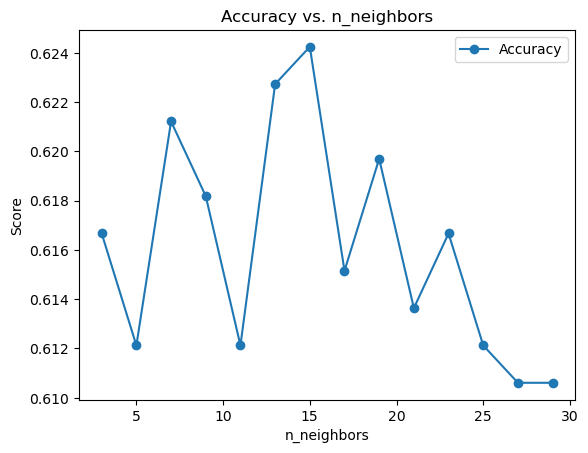

In [60]:
#  Accuracy 
plt.plot(neighbors_range, accuracies, marker='o', label='Accuracy')
plt.xlabel('n_neighbors')
plt.ylabel('Score')
plt.title('Accuracy vs. n_neighbors')
plt.legend()
plt.show()

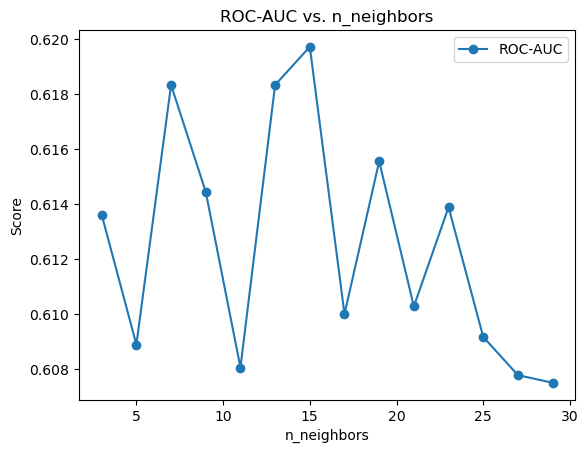

In [61]:
plt.plot(neighbors_range, roc_aucs, marker='o', label='ROC-AUC')
plt.xlabel('n_neighbors')
plt.ylabel('Score')
plt.title('ROC-AUC vs. n_neighbors')
plt.legend()
plt.show()

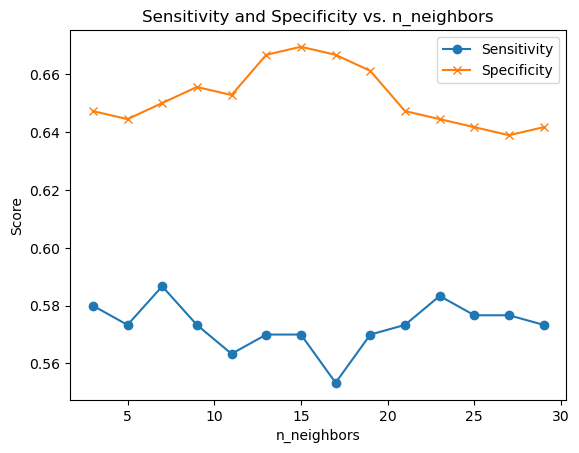

In [62]:
plt.plot(neighbors_range, sensitivities, marker='o', label='Sensitivity')
plt.plot(neighbors_range, specificities, marker='x', label='Specificity')
plt.xlabel('n_neighbors')
plt.ylabel('Score')
plt.title('Sensitivity and Specificity vs. n_neighbors')
plt.legend()
plt.show()

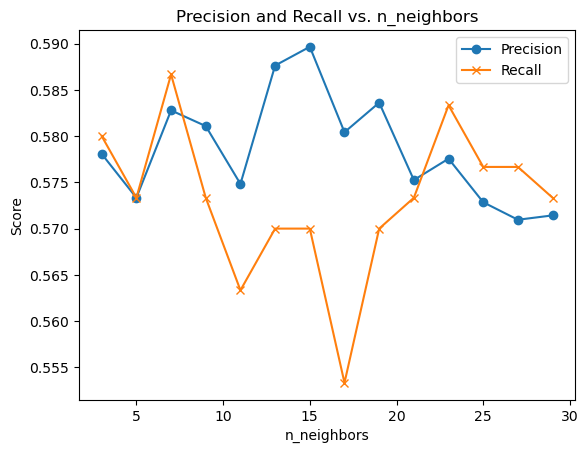

In [63]:
plt.plot(neighbors_range, precisions, marker='o', label='Precision')
plt.plot(neighbors_range, recalls, marker='x', label='Recall')
plt.xlabel('n_neighbors')
plt.ylabel('Score')
plt.title('Precision and Recall vs. n_neighbors')
plt.legend()
plt.show()

In [64]:
print(f"Highest accuracy: {best_accuracy}, n_neighbors: {best_n_neighbors}")
print(f"Best ROC-AUC: {best_roc_auc}")
print(f"Best Sensitivity: {best_sensitivity}")
print(f"Best Specificity: {best_specificity}")
print(f"Best Precision: {best_precision}")
print(f"Best Recall: {best_recall}")

Highest accuracy: 0.6242424242424243, n_neighbors: 15
Best ROC-AUC: 0.6197222222222222
Best Sensitivity: 0.5866666666666667
Best Specificity: 0.6694444444444444
Best Precision: 0.5896551724137931
Best Recall: 0.5866666666666667
